### comment out the code below to install required packages

In [1]:
# code to install all the packages we need
# %pip install numpy
# %pip install pandas
# %pip install yfinance
# %pip install requests
# %pip install beautifulsoup4
# %pip install scikit-learn
# %pip install TA-Lib
# %pip install joblib
# %pip install pickle-mixin
# %pip install riskfolio-lib
# %pip install matplotlib

In [2]:
# in case we have to install some packages with conda
# %conda install -c conda-forge ta-lib
# %conda install -c conda-forge yfinance
# %conda install -c conda-forge bs4
# %conda install requests
# %conda install joblib
# %conda install -c conda-forge lightgbm
# %

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf

import os

import requests
import bs4 as bs
import datetime
import time
import threading
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV  
from sklearn.model_selection import RandomizedSearchCV

import joblib
import pickle

from scipy.stats import randint, uniform

import talib as ta
from talib import MA_Type

import matplotlib.pyplot as plt
import warnings

In [19]:
# # if folder 'model' does not exist yet, create folder
current_dir = os.getcwd()
model_path = os.path.join(current_dir, "model")
if not os.path.exists(model_path):
     os.mkdir(model_path)
     print(f"Folder {model_path} created successfully.")
else:
     print(f"Folder {model_path} already exists.")
        
model_path = model_path + '/'
model_path

Folder /model already exists.


'/model/'

In [5]:
# the following line gets the bucket name attached to our cluster
bucket = 'qst843-duck'

# specifying the path to our bucket where the data is located (no need to edit this path anymore)
model_path = "gs://" + bucket + "/notebooks/jupyter/model"
print(model_path)

gs://qst843-duck/notebooks/jupyter/model


In [6]:
#get S&P tickers list from wikipedia
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

tickers = []

for row in table.findAll('tr')[1:]:
    ticker_name = row.findAll('td')[0].text
    tickers.append(ticker_name)

#clean list
tickers = [s.replace('\n', '') for s in tickers]

#get data from yfin
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now().strftime("%Y-%m-%d")
data = yf.download(tickers, start=start, end=end)

print(data)
#TODO: note we might also need to get data from tws.

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
             Adj Close                                                 \
                     A        AAL         AAP        AAPL        ABBV   
Date                                                                    
2010-01-04   20.268339   4.496877   36.703850    6.505280         NaN   
2010-01-05   20.048176   5.005957   36.485683    6.516526         NaN   
2010-01-06   19.976940   4.798553   36.803837    6.412873         NaN   
2010-01-07   19.951042   4.939965   36.794754    6.401018         NaN   
2010-01-08   19.944557   4.845691   36.940182    6.443573         NaN   
...                ...        ...         ...         ...         ...   
2023-04-10  138.020004  14.150000  118.901749  162.029999  159.809845   
2023-04-11  138.520004  14.320000  120.669617  160.800003  

In [7]:
# data.to_pickle('SP500_data.pkl')

In [8]:
# data = pd.read_pickle('SP500_data.pkl')

# data cleaning part

In [9]:
#clean data
df = data.stack().reset_index().rename(index=str, columns={"level_1": "Symbol"}).sort_values(['Symbol','Date'])
df.set_index('Date', inplace=True)

#drop tickers not in the list
tickers.remove("BRK.B")
tickers.remove("BF.B")
tickers.remove("FTV")
tickers.remove("GEHC")

#sort by group
groups = df.groupby("Symbol")
Ticker_Data = {}

for t in tickers:
    Ticker_Data[t] = groups.get_group(t)

In [10]:
df

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-01-04,A,20.268339,22.389128,22.625179,22.267525,22.453505,3815561.0
2010-01-05,A,20.048176,22.145924,22.331903,22.002861,22.324751,4186031.0
2010-01-06,A,19.976940,22.067240,22.174536,22.002861,22.067240,3243779.0
2010-01-07,A,19.951042,22.038628,22.045780,21.816881,22.017166,3095172.0
2010-01-08,A,19.944557,22.031473,22.067240,21.745352,21.917025,3733918.0
...,...,...,...,...,...,...,...
2023-04-10,ZTS,170.869995,170.869995,171.220001,166.740005,167.899994,1686100.0
2023-04-11,ZTS,171.210007,171.210007,172.429993,170.830002,171.550003,1197900.0
2023-04-12,ZTS,171.449997,171.449997,174.789993,171.160004,172.910004,1852200.0


In [11]:
warnings.filterwarnings('ignore')

last_X = {} # use the last day's data to make prediction

for t in tickers:
    # AD - Chaikin A/D Line :Volume Indicator
    Ticker_Data[t].loc[:,'AD'] = ta.AD(Ticker_Data[t]['High'], Ticker_Data[t]['Low'], Ticker_Data[t]['Close'], Ticker_Data[t]['Volume'])

    # calculate the width of BBand (volatility indicator)
    upper_band, middle_band, lower_band = ta.BBANDS(Ticker_Data[t]['Close'],
                                            timeperiod=10)
    Ticker_Data[t].loc[:,'BBandwidth'] = (upper_band - lower_band) / middle_band
    # calculate macd
    macd, macd_signal, macd_hist = ta.MACD(Ticker_Data[t]['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    Ticker_Data[t].loc[:, 'Macd'] = macd

    # calculate momentum
    Ticker_Data[t].loc[:,'Momentum15d'] = ta.MOM(Ticker_Data[t]['Close'],timeperiod=15)
    Ticker_Data[t].loc[:,'Momentum10d'] = ta.MOM(Ticker_Data[t]['Close'],timeperiod=10)
    Ticker_Data[t].loc[:,'Momentum5d'] = ta.MOM(Ticker_Data[t]['Close'],timeperiod=5)
    
    Ticker_Data[t].loc[:,'RSI'] = ta.RSI(np.array(Ticker_Data[t]['Close']), timeperiod=5)

    Ticker_Data[t].loc[:,'ROC'] = ta.ROC(np.array(Ticker_Data[t]['Close']), timeperiod=5)

    last_X[t] = Ticker_Data[t].iloc[-1,:].drop(['Symbol', 'Close', 'High', 'Low', 'Open', 'Volume'])

    Ticker_Data[t].loc[:,'Returns'] = np.log(Ticker_Data[t]['Open'].shift(-5)/Ticker_Data[t]['Open']) # I want to predict the return of 5 business days after today.

    Ticker_Data[t].dropna(inplace =True)

    # get rid of the 30% data in the middle to reduce noise.
    Ticker_Data[t]=Ticker_Data[t].sort_values(by=['Returns'])
    Ticker_Data[t]=pd.concat([Ticker_Data[t].iloc[:int(np.floor(len(Ticker_Data[t]['Returns'])*0.35)),:],
                            Ticker_Data[t].iloc[int(np.floor(len(Ticker_Data[t]['Returns'])*0.85)):,:]])

warnings.filterwarnings('default')

# stock selection

In [12]:
X = []
Y = []

for i in tickers:
    X.append(Ticker_Data[i].drop(columns=['Symbol','Returns', 'Close', 'High', 'Low', 'Open', 'Volume']))
    Y.append(Ticker_Data[i]['Returns'].apply(lambda x:1 if (x>np.mean(Ticker_Data[i]['Returns']) and (x>0)) else -1)) # 1 or -1
# turn list into dataframe
X = pd.concat(X)
Y = pd.concat(Y)

In [13]:
# dictionary to store the best_scores of each model
best_scores = {}

# RandomForest

In [14]:
# only need to excute it once if it takes too long
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# define the hyperparameter search space
# define the hyperparameter search space
param_dist = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': randint(3, 25),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 6),
    'classifier__max_features': ['sqrt', 'log2'],
}
# define the search parameters
n_iter_search = 10  # number of parameter combinations to try
cv = 5  # number of cross-validation folds

# randomsearch
clf = RandomizedSearchCV(pipe, param_dist, n_iter=n_iter_search, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf.fit(X, Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__max_depth=3, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=385; total time= 5.9min
[CV] END classifier__max_depth=22, classifier__max_features=sqrt, classifier__min_samples_leaf=5, classifier__min_samples_split=9, classifier__n_estimators=168; total time=11.0min


/opt/conda/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__max_depth=16, classifier__max_features=log2, classifier__min_samples_leaf=3, classifier__min_samples_split=5, classifier__n_estimators=107; total time= 6.1min
[CV] END classifier__max_depth=15, classifier__max_features=log2, classifier__min_samples_leaf=5, classifier__min_samples_split=6, classifier__n_estimators=459; total time=25.0min
[CV] END classifier__max_depth=12, classifier__max_features=log2, classifier__min_samples_leaf=3, classifier__min_samples_split=5, classifier__n_estimators=448; total time=21.2min
[CV] END classifier__max_depth=19, classifier__max_features=log2, classifier__min_samples_leaf=3, classifier__min_samples_split=8, classifier__n_estimators=220; total time=14.1min
[CV] END classifier__max_depth=3, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=385; total time= 5.9min
[CV] END classifier__max_depth=22, classifier__max_features=sqrt, classifier__min_samples_leaf=5, cla

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions={'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4d985367d0>,
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4d98534520>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4d98537c10>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4dbc7bd000>},
                   scoring='roc_auc', verbose=2)

In [15]:
best_scores['randomforest'] = clf.best_score_

In [16]:
# print(clf.cv_results_)
# print('--------------------')
# print(clf.scorer_)
# print('--------------------')
print(clf.best_score_)
print('--------------------')
print(clf.best_params_)

0.6676664960602617
--------------------
{'classifier__max_depth': 15, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 459}


In [ ]:
# retrain the pipeline with the best parameters on the entire dataset
best_pipe = pipe.set_params(**clf.best_params_)
# fit it to the entire data.
best_pipe.fit(X, Y)

# save the resulting model to disk
# joblib.dump(best_pipe, 'rf_model.joblib')
joblib.dump(best_pipe, model_path + 'rf_model_3.joblib')

### Feature importance based on mean decrease in impurity(random forest)

In [41]:
importances = best_pipe[1][1].feature_importances_
std = np.std([tree.feature_importances_ for tree in best_pipe[1].estimators_], axis=0)

TypeError: 'LGBMClassifier' object is not subscriptable

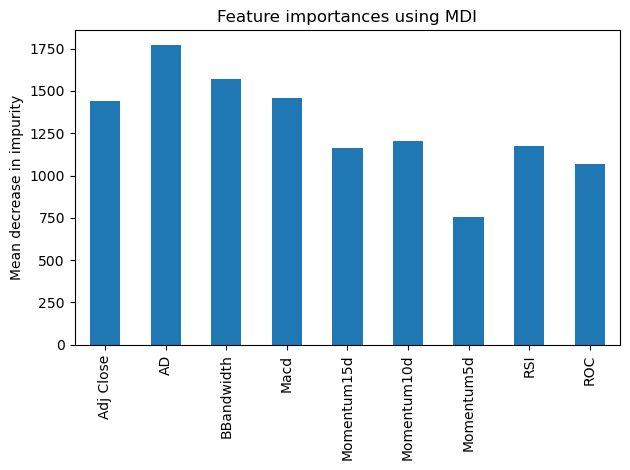

In [42]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Logistic Regression

sometimes the line search algorithm does not converge(depends on the parameters)

In [76]:
# only need to execute it once if it takes too long
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# define the hyperparameter search space
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__penalty': ['none', 'l2'],
    'classifier__solver': ['newton-cg', 'lbfgs'],
    'classifier__max_iter': [10000, 200000],
}

# define the search parameters
n_iter_search = 10  # number of parameter combinations to try
cv = 5  # number of cross-validation folds

# randomsearch
clf = RandomizedSearchCV(pipe, param_dist, n_iter=n_iter_search, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf.fit(X, Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__C=1000, classifier__max_iter=809, classifier__penalty=l2, classifier__solver=lbfgs; total time=   1.3s
[CV] END classifier__C=10, classifier__max_iter=452, classifier__penalty=none, classifier__solver=lbfgs; total time=   1.2s
[CV] END classifier__C=1000, classifier__max_iter=719, classifier__penalty=l2, classifier__solver=lbfgs; total time=   1.2s
[CV] END classifier__C=1000, classifier__max_iter=719, classifier__penalty=l2, classifier__solver=lbfgs; total time=   1.3s
[CV] END classifier__C=0.1, classifier__max_iter=165, classifier__penalty=l2, classifier__solver=newton-cg; total time=   6.0s
[CV] END ....classifier__var_smoothing=4.281332398719396e-10; total time=   0.5s
[CV] END ...classifier__var_smoothing=3.3598182862837814e-08; total time=   0.6s
[CV] END ...classifier__var_smoothing=1.8329807108324374e-09; total time=   0.3s
[CV] END classifier__colsample_bytree=0.4, classifier__learning_rate=0.00

/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.01, classifier__max_iter=333, classifier__penalty=l2, classifier__solver=lbfgs; total time=   1.2s
[CV] END classifier__C=1, classifier__max_iter=346, classifier__penalty=none, classifier__solver=newton-cg; total time=   7.7s
[CV] END classifier__C=1000, classifier__max_iter=955, classifier__penalty=none, classifier__solver=lbfgs; total time=   1.1s
[CV] END ....................classifier__var_smoothing=1e-10; total time=   0.5s
[CV] END ...classifier__var_smoothing=3.3598182862837814e-08; total time=   0.5s
[CV] END ...classifier__var_smoothing=1.8329807108324374e-09; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8999999999999999, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__min_child_samples=94, classifier__min_child_weight=0.1, classifier__n_estimators=378, classifier__num_leaves=48, classifier__reg_alpha=1000.0, classifier__reg_lambda=1.0, classifier__subsample=0.7; total time=  15.7s
[CV] END classifier__colsample_bytree

/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/miniconda3/lib/python3.10/site-packages/scipy/optimize/_lin

In [77]:
best_scores['linearregression'] = clf.best_score_

In [78]:
print(clf.best_score_)
print('--------------------')
print(clf.best_params_)

0.6182704180246354
--------------------
{'classifier__solver': 'newton-cg', 'classifier__penalty': 'l2', 'classifier__max_iter': 200000, 'classifier__C': 1000}


In [79]:
# retrain the pipeline with the best parameters on the entire dataset
best_pipe = pipe.set_params(**clf.best_params_)
# fit it to the entire data.
best_pipe.fit(X, Y)

# save the resulting model to disk
joblib.dump(best_pipe, model_path + 'lr_model.joblib')

['/model/lr_model.joblib']

### feature importance based on coefficient.

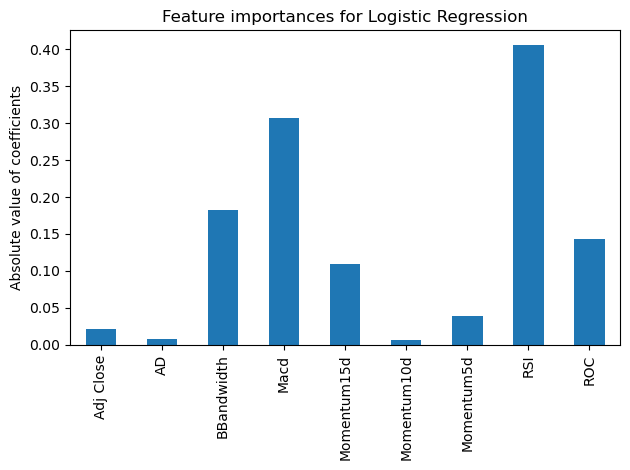

In [62]:
#get the coefficients of the best logistic regression model (feature importance)
importances = np.abs(clf.best_estimator_.named_steps['classifier'].coef_[0])

# Create a Pandas Series of Feature Importance
feature_importances = pd.Series(importances, index=X.columns)

# plot
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for Logistic Regression")
ax.set_ylabel("Absolute value of coefficients")
fig.tight_layout()
plt.show()

# naive bayes

In [63]:
from sklearn.naive_bayes import GaussianNB

# only need to execute it once if it takes too long
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

# GaussianNB doesn't have many hyperparameters to tune
param_dist = {
    'classifier__var_smoothing': np.logspace(-10, -6, num=20)
}

# define the search parameters
n_iter_search = 10  # number of parameter combinations to try
cv = 5  # number of cross-validation folds

# randomsearch
clf = RandomizedSearchCV(pipe, param_dist, n_iter=n_iter_search, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf.fit(X, Y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier', GaussianNB())]),
                   n_jobs=-1,
                   param_distributions={'classifier__var_smoothing': array([1.00000000e-10, 1.62377674e-10, 2.63665090e-10, 4.28133240e-10,
       6.95192796e-10, 1.12883789e-09, 1.83298071e-09, 2.97635144e-09,
       4.83293024e-09, 7.84759970e-09, 1.27427499e-08, 2.06913808e-08,
       3.35981829e-08, 5.45559478e-08, 8.85866790e-08, 1.43844989e-07,
       2.33572147e-07, 3.79269019e-07, 6.15848211e-07, 1.00000000e-06])},
                   scoring='roc_auc', verbose=2)

In [64]:
best_scores['naivebayes'] = clf.best_score_

In [65]:
print(clf.best_score_)
print('--------------------')
print(clf.best_params_)

0.5917466537305556
--------------------
{'classifier__var_smoothing': 1.438449888287663e-07}


In [66]:
# retrain the pipeline with the best parameters on the entire dataset
best_pipe = pipe.set_params(**clf.best_params_)
# fit it to the entire data.
best_pipe.fit(X, Y)

# save the resulting model to disk
joblib.dump(best_pipe, model_path + 'nb_model.joblib')

['/model/nb_model.joblib']

For naive Bayes models, the concept of feature importance is not as straightforward as other models. The Naive Bayes model is based on Bayes' theorem, in which the conditional probabilities of each feature are assumed to be independent. This means that there are no direct weights or coefficients between features that can be used directly to indicate feature importance.

# lightgbm

In [ ]:
# only need to execute it once if it takes too long
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', lgb.LGBMClassifier())
])

# define the hyperparameter search space
param_dist = {
    'classifier__n_estimators': randint(50, 500),
    'classifier__learning_rate': np.logspace(-3, 0, num=10),
    'classifier__max_depth': randint(3, 25),
    'classifier__num_leaves': randint(7, 50),
    'classifier__min_child_samples': randint(20, 100),
    'classifier__min_child_weight': np.logspace(-3, 3, num=7),
    'classifier__subsample': np.linspace(0.4, 1.0, num=7),
    'classifier__colsample_bytree': np.linspace(0.4, 1.0, num=7),
    'classifier__reg_alpha': np.logspace(-3, 3, num=7),
    'classifier__reg_lambda': np.logspace(-3, 3, num=7),
}

# define the search parameters
n_iter_search = 50  # number of parameter combinations to try
cv = 5  # number of cross-validation folds

# randomsearch
clf = RandomizedSearchCV(pipe, param_dist, n_iter=n_iter_search, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf.fit(X, Y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('classifier', LGBMClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'classifier__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'classifi...
                                        'classifier__num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f4e70ac3580>,
                                        'classifier__reg_alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'classifier__reg_lambda': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'classifier__subsample': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   scoring='roc_auc', verbose=2)

### feature importance based on split gain

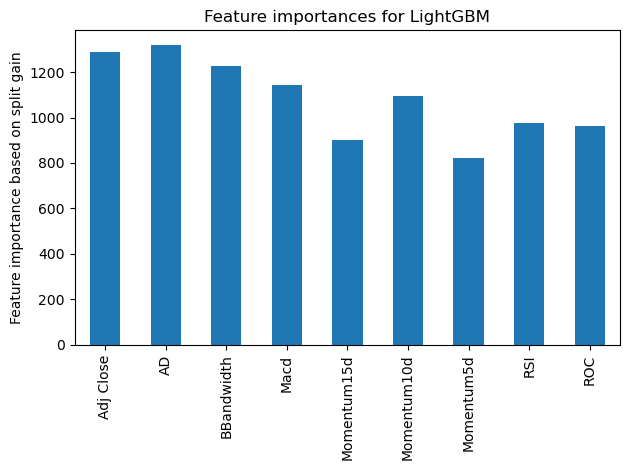

In [ ]:
best_lgbm_model = clf.best_estimator_.named_steps['classifier']
# feature importance
importances = best_lgbm_model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)

# plot
fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for LightGBM")
ax.set_ylabel("Feature importance based on split gain")
fig.tight_layout()
plt.show()

In [ ]:
best_scores['lightgbm'] = clf.best_score_

In [ ]:
print(clf.best_score_)
print('--------------------')
print(clf.best_params_)

0.667776941366208
--------------------
{'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.21544346900318823, 'classifier__max_depth': 16, 'classifier__min_child_samples': 51, 'classifier__min_child_weight': 1.0, 'classifier__n_estimators': 278, 'classifier__num_leaves': 36, 'classifier__reg_alpha': 0.001, 'classifier__reg_lambda': 1000.0, 'classifier__subsample': 0.4}


In [ ]:
# retrain the pipeline with the best parameters on the entire dataset
best_pipe = pipe.set_params(**clf.best_params_)
# fit it to the entire data.
best_pipe.fit(X, Y)

# save the resulting model to disk
joblib.dump(best_pipe, model_path + 'gbm_model.joblib')

['/model/gbm_model.joblib']

# load the best model

In [ ]:
# get the name of the best model
best_model_name = max(best_scores, key=best_scores.get)
print(best_model_name)

lightgbm


In [81]:
best_pipe = joblib.load(model_path + 'gbm_model.joblib')
# retrain the model with updated data

# select top ten stocks

In [82]:
probs = []
for t in tickers:
    tmp_X = last_X[t].reset_index(drop=True).to_numpy().reshape(1, -1)
    last_X_df = pd.DataFrame(tmp_X, columns=last_X[t].index)
    probs.append(best_pipe.predict_proba(last_X_df)[:,1][0]) #  how close it is to 1

# sort probabilities in descending order
sorted_probs = np.sort(probs)[::-1]

# set threshold for top ten closest to 1
threshold = sorted_probs[9]

# set top ten closest to 1 to 1, and the rest to 0
tmp_index = np.zeros(len(probs))
tmp_index[probs >= threshold] = 1
tmp_index = tmp_index.astype(int)


In [83]:
portfolio_list = [tickers[i] for i in range(len(tmp_index)) if tmp_index[i] == 1]
portfolio_list

['TECH', 'BLK', 'C', 'ETSY', 'EXPE', 'EXPD', 'FIS', 'HON', 'JPM', 'SLB']

In [ ]:
with open('portfolio_list.pickle', 'wb') as f:
    pickle.dump(portfolio_list, f)